Author: megan Tabbutt
Last Update: 3_31_21

##### Purpose:


### Issues: 
1. pyproj depreciation issues
2. Only allowed to do 500 queries to census demographics API, so need to build in something with this. Maybe switch to blockgroups if tracts are over 500? request an API key from user? 

3. LOGIC ERROR: when querying blockgroup < tract < county < state



### To-Do:
1. class-ify


### Resources: 

- geography glossery: https://www.census.gov/programs-surveys/geography/about/glossary.html#par_textimage_4

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
from shapely.geometry import Point
from pyproj import Proj, transform
import geopandas as gpd
import matplotlib.pyplot as plt
import requests, json
from mpl_toolkits.axes_grid1 import make_axes_locatable

P3857 = Proj(init='epsg:3857') # mercader special, meters
P4326 = Proj(init='epsg:4326') # lat/lon

/Users/megantabbutt/Library/Python/3.8/lib/python/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/megantabbutt/Library/Python/3.8/lib/python/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/megantabbutt/Library/Python/3.8/lib/python/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the

# 1. Get the census tracts that overlap the bus system and do some conversions

In [3]:
# Pull in the latitude and longitude from gtfs data 
gtfs_data_path = "data/mmt_gtfs/"
lat_lon_file = 'stops.csv'
lat_lon_df = pd.read_csv(gtfs_data_path + lat_lon_file)
lat_lon_df.head(3)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1662,1662,E Gorham & N Blount (WB),This stop (#1662) is westbound on the 698 bloc...,43.082455,-89.380990,MMT,CMAD,0,NaN,1,270.0,1,E Gorham,698,N Blount
1,2437,2437,Toepfer & Birch (NB),This stop (#2437) is northbound on the 441 blo...,43.058547,-89.441740,MMT,CMAD,0,NaN,1,0.0,1,Toepfer,441,Birch
2,7931,7931,North Star & Orion (NB),This stop (#7931) is northbound on the 741 blo...,43.087951,-89.279047,MMT,CMAD,0,NaN,3,0.0,1,North Star,741,Orion


In [4]:
# Convert to shapely point objects in tuples
ID_points = [Point(lat_lon_df['stop_lon'][i], lat_lon_df['stop_lat'][i]) for i in range(len(lat_lon_df))]
#ID_points[0].coords[:]

In [5]:
farthest_points = [ID_points[0] for i in range(4)]

for point in ID_points:
    if point.y > farthest_points[0].y: # north = largest y (lat)
        farthest_points[0] = point
    if point.x > farthest_points[1].x: # east = largest x (lon)
        farthest_points[1] = point
    if point.y < farthest_points[2].y: # south = smallest y (lat)
        farthest_points[2] = point
    if point.x < farthest_points[3].x: # west = smallest x (lon)
        farthest_points[3] = point

farthest_points_mercader = [0, 0, 0, 0]
for i, point in enumerate(farthest_points):
    x, y = transform(P4326, P3857, point.x, point.y)
    farthest_points_mercader[i] = (x, y)
            
#farthest_points_mercader

<ipython-input-5-b8c20938ebce>:15: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = transform(P4326, P3857, point.x, point.y)


max_sep:  17757.96347006876


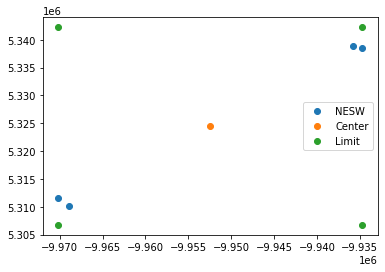

In [6]:
# Find the center of the system: 
center_lon = (farthest_points_mercader[3][0] + 
              abs(farthest_points_mercader[1][0] - farthest_points_mercader[3][0])/2)
center_lat = (farthest_points_mercader[2][1] + 
              abs(farthest_points_mercader[0][1] - farthest_points_mercader[2][1])/2)

max_sep = max(abs(farthest_points_mercader[1][0] - farthest_points_mercader[3][0])/2, 
              abs(farthest_points_mercader[0][1] - farthest_points_mercader[2][1])/2)

print("max_sep: ", max_sep)

xs = [farthest_points_mercader[i][0] for i in range(len(farthest_points_mercader))]
ys = [farthest_points_mercader[i][1] for i in range(len(farthest_points_mercader))]

plt.scatter(xs, ys, label='NESW')
plt.scatter(center_lon, center_lat, label='Center')
plt.scatter([center_lon+max_sep, center_lon-max_sep, center_lon-max_sep, center_lon+max_sep],
            [center_lat+max_sep, center_lat+max_sep, center_lat-max_sep, center_lat-max_sep], label='Limit')
plt.legend()
plt.show()

In [7]:
center_lon = round(center_lon, 2)
center_lat = round(center_lat, 2)
max_sep = round(max_sep, 2)
max_sep + 2000

19757.96

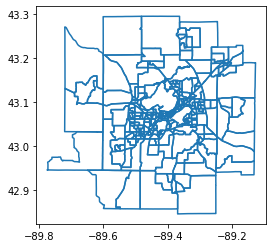

In [8]:
base_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/11/query?"
geometry = "geometry=" + str(round(center_lon, 2)) + "%2C" + str(round(center_lat, 2)) + "&"
mid_url = "geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&"
distance = "distance=" + str(round(max_sep, 2) + 2000) + "&units=esriSRUnit_Meter&"
end_url = "outFields=STATE%2CCOUNTY%2CTRACT%2CBLKGRP&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson"

url = base_url + geometry + mid_url + distance + end_url

df = gpd.read_file(url)
df.boundary.plot()
plt.show()

# 2. Get the demographics Data:

https://api.census.gov/data/2019/acs/acs5.html

https://api.census.gov/data/2019/acs/acs5/examples.html

https://api.census.gov/data/2019/acs/acs5/groups.html


Races:

    'Total':'B02001_001E', 

    'White alone':'B02001_002E',

    'Black or African American alone':'B02001_003E', 
    
    'American Indian and Alaska Native alone':'B02001_004E', 

    'Asian alone':'B02001_005E', 

    'Native Hawaiian and Other Pacific Islander alone':'B02001_006E'

In [9]:
df.head(3)

,STATE,COUNTY,TRACT,BLKGRP,geometry
0,55,025,012900,2,"POLYGON ((-89.71995 43.26540, -89.71995 43.261..."
1,55,025,010800,2,"POLYGON ((-89.56397 42.99890, -89.56484 42.997..."
2,55,025,010903,1,"POLYGON ((-89.57806 43.03107, -89.57799 43.030..."


In [10]:
Race = {'Total':'B02001_001E', 'White alone':'B02001_002E', 'Black or African American alone':'B02001_003E', 
            'American Indian and Alaska Native alone':'B02001_004E', 'Asian alone':'B02001_005E', 
            'Native Hawaiian and Other Pacific Islander alone':'B02001_006E'}

### each Query takes time but to query multiple demographics for each tract is negligable so just query all the things you want from each tract together. 

In [11]:
combined_data = []

j = 0
for row in df.iterrows():
    state = row[1]['STATE']
    tract = row[1]['TRACT']
    county = row[1]['COUNTY']
    blockgroup = row[1]['BLKGRP']
    demographic = Race['Total'] + "," + Race['White alone'] + "," + Race['Black or African American alone']
    
    url_acs = "https://api.census.gov/data/2019/acs/acs5?"
    url_demographic = "get=NAME," + str(demographic) + "&"
    url_location = "for=block%20group:" + str(blockgroup) + "&in=state:" + str(state) + "%20county:" + str(county) + "%20tract:" + str(tract)
    url = url_acs + url_demographic + url_location
    
    resp = requests.get(url)
    data = json.loads(resp.text)
    
    if len(combined_data) == 0:
        combined_data.append(data[0])
    combined_data.append(data[1])
    
    j +=1 
    #if j == 25:
        #break

In [12]:
combined_df = pd.DataFrame(combined_data[1:], columns=combined_data[0])
combined_df.rename(columns={'tract':'TRACT', 'state':'STATE', 'county':'COUNTY', 'block group':'BLKGRP'}, inplace=True)
combined_df.head(3)

,NAME,B02001_001E,B02001_002E,B02001_003E,STATE,COUNTY,TRACT,BLKGRP
0,"Block Group 2, Census Tract 129, Dane County, ...",1844,1831,0,55,025,012900,2
1,"Block Group 2, Census Tract 108, Dane County, ...",1802,1247,264,55,025,010800,2
2,"Block Group 1, Census Tract 109.03, Dane Count...",3575,3096,0,55,025,010903,1


In [13]:
joined_df = df.merge(combined_df, on=['TRACT', 'STATE', 'COUNTY', 'BLKGRP'])
joined_df.head(3)

,STATE,COUNTY,TRACT,BLKGRP,geometry,NAME,B02001_001E,B02001_002E,B02001_003E
0,55,025,012900,2,"POLYGON ((-89.71995 43.26540, -89.71995 43.261...","Block Group 2, Census Tract 129, Dane County, ...",1844,1831,0
1,55,025,010800,2,"POLYGON ((-89.56397 42.99890, -89.56484 42.997...","Block Group 2, Census Tract 108, Dane County, ...",1802,1247,264
2,55,025,010903,1,"POLYGON ((-89.57806 43.03107, -89.57799 43.030...","Block Group 1, Census Tract 109.03, Dane Count...",3575,3096,0


In [21]:
Total = [int(i) for i in list(joined_df['B02001_001E'])]
White = [int(i) for i in list(joined_df['B02001_002E'])]
joined_df['percentWhite'] = [White[i] / Total[i] if Total[i] != 0 else float("Nan") for i in range(len(Total))]

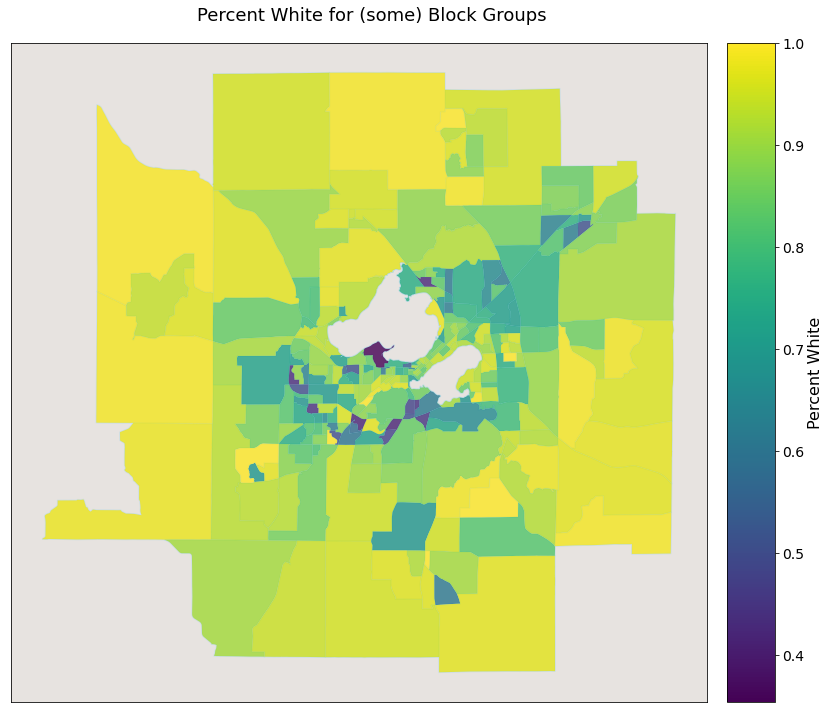

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad = -1.5)

joined_df.plot(column='percentWhite', ax=ax, legend=True, cax=cax, cmap='viridis', alpha=.8, zorder=1)
fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=14)

df.boundary.plot(color='lightblue', alpha=.5, ax=ax, zorder=0)

cax.set_ylabel("Percent White", fontsize=16)        
        
ax.set_facecolor("#e7e3e0")
ax.set_yticks([])
ax.set_xticks([])

fig.suptitle("Percent White for (some) Block Groups", fontsize=18, x=.55, y=.82)
plt.show()